# Desenvolvimento do DBSCAN <h1>

Primeiro projeto da disciplina MC886 2021.1

Desenvolvido por Felipe Arruda (RA: 196862) e Leonardo Koike (RA: 201332)

In [3]:
#imports das bibliotecas necessárias
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from sklearn import preprocessing

# Leitura e tratamento 
dos dados disponibilizados pelo trabalho para a utilização pelo algorítmo

In [4]:
# Dados carregados em um numpy array
data = np.loadtxt('cluster.dat')

In [5]:
# Dados normalizados que serão utilizados como uma comparação 
data_norm = data/data.max(axis=0)

In [6]:
# divisão para dados de treinamento e dados de teste
np.random.shuffle(data_norm)
train_index_norm = int(data_norm.shape[0]*0.9)
train_data_norm,test_data_norm = np.vsplit(data_norm,[train_index_norm])

# Algorítmo 

## Para realizar o treino do modelo, utilizamos a função *dbscan*
Utilizamos neste notebook é o DBSCAN como apresentado em sala de aula.

A função recebe o dado para treinamento do modelo e os parâmetros para o algoritmo do DBSCAN (número de vizinhos e raio da vizinhança)

O retorno da função consiste de: 
* todos os core points das vizinhanças
* todos os border poitns de uma dada vizinhança
* todos os outliers do conjunto de dados
* um inteiro representando o número de cluster(ou vizinhanças)

O algoritmo passa por todos os pontos disponíveis do dataset com o auxilio de duas listas: availabe_points e index_points. A primeira reflete todos os pontos que ainda não foram localizados pelo algoritmo, já a segunda são pontos que o algoritmo já conseguiu localizar, mas ainda não foram classificados.

A lógica do DBSCAN segue o seguinte fluxo:
~~~
Enquanto TRUE

    se existem pontos dentro de index_points

        retiro o próximo ponto a ser avaliado de index_points

    se não

        aqui existe a lógica que trata da validação do cluster e dos outliers, bem como a 
          criação um novo cluster dentro do dicionário com os pontos avaliados como core_points e border_points. Essas 2 listas são limpas para mais uma rodada.

        se ainda existem availabe_points

            retiro o próximo ponto a ser avaliado de availabe_points

        se não

            o código realiza um break, já que todos os pontos do dataset foram avaliados

    com o ponto a ser avaliado como point, ele é retirado de availabe_points

    calculamos a distância euclidiana de point para todos os outros pontos do dataset

    são classificados como neighbors todos os pontos que tem um raio menor que radius_of_neighborhood do ponto avaliado

    core_neighbor_flag é uma flag para auxiliar na classificação de border_points

    Para todo neighbor de point
        se este neighbor não foi localizado ainda (não está em index_points) e nem avaliado (está em availabe_points)
            ele é adicionado à index_points
        se algum dos neighbors é core, a flag é classificada como 1
    
    agora para a classificação:
    se o número de neighbors é maior que number_of_neighbors, point é classificado como core
    se não
        se a core_neighbor_flag é 1, ou seja, existe um core point na vizinhança de point, ele é classificado como border
        se não ele é um outlier
~~~

## Para realizar o teste do modelo com o conjunto de dados de teste, existe a função *dbscan_fit*

Nesta função recebemos como parâmetros o conjunto de dados de teste, que são os pontos a serem avaliados, os core_points do modelo treinado e o raio da vizinhança a ser considerado.

Nele fazemos a busca por todos os clusters aos quais os core_points representam, a fim de testar se a distância dos pontos a serem avaliados do conjunto de teste está dentro do raio da vizinhança definido. Se existe algum vizinho dentro do raio, este ponto é classificado no mesmo cluster deste vizinho.

Depois de avaliar todos os core_points, se ainda houver availabe_points estes são classificados como outliers do teste.

A função retorna um dicionário com o mapeamento dos pontos de teste aos mesmos clusters do teste e uma lista com todos os outliers do teste 

In [7]:
def dbscan(data_in: np.ndarray, radius_of_neighborhood: float, number_of_neighbors: int):
    #inicialização da lista de classificação dos pontos
    core_points = []
    border_points = []
    outliers_points = []

    #cluster ajudará na cassificação dos cores junto aos clusters, os dois dicionários serão retornados
    cluster = 0
    cluster_cores = {}
    cluster_borders = {}

    #mepamento de todos os pontos do dataset, mantem a lista de quais não foram visitados ainda
    availabe_points = []
    for i in range(data_in.shape[0]):
        availabe_points.append(i)
    
    #escolha aleatoria de um ponto
    index_list = [np.random.choice(data_in.shape[0])]
    
    #enquanto ainda houver pontos não visitados, este laço é executado
    while True:
        
        #se existe elemento em index_list, ele retira o topo e continua o processamento
        #se não ele escolhe um aleatório dos pontos disponíveis
        if index_list:
            point = index_list.pop(0)
        else:
            if core_points:
                #etapa para verificar se outliers realmente são outliers levando em consideração os dicionários de corepoints formados
                for i in outliers_points:
                    
                    #calcula a distância entre o ponto escolhido e todos os outros do dataset
                    dist = np.linalg.norm(data_in[i]-data_in[core_points],axis=1)

                    neighbors = np.where(dist <= radius_of_neighborhood)[0]

                    core_neighbor_flag = 0
                    for i in neighbors:
                        if not core_neighbor_flag and i in core_points:
                            core_neighbor_flag = 1

                    #se algum dos vizinhos deste "outlier" em questão for core, ele é reclassificado como border
                    if core_neighbor_flag:
                        border_points.append(i)
                        outliers_points.remove(i)

                # Podemos montar os dicionários dos clusters, classificando como um novo cluster, iterando a variável cluster, 
                # já que chegamos em todos os pontos alcançáveis de acordo com os parâmetros passados para a função
            
                cluster_cores[cluster] = np.array(core_points)
                cluster_borders[cluster] = np.array(border_points)
                cluster += 1

                #limpeza das listas já classificadas em um cluster
                core_points.clear()
                border_points.clear()

            #se ainda existem pontos disponíveis
            if availabe_points:
                #escolha de um ponto aleatório dentro dos pontos disponíveis
                point = availabe_points[np.random.choice(len(availabe_points))]
            else:
                #saia do loop se acabarem os pontos disponíveis
                break
        
        #remove o ponto utilizado da lista de pontos disponíveis
        availabe_points.remove(point)
        
        #calcula a distância entre o ponto escolhido e todos os outros do dataset
        dist = np.linalg.norm(data_in[point]-data_in,axis=1)

        #identifica os vizinhos do ponto escolhido de acordo com o raio passado como parâmetro
        neighbors = np.where(dist <= radius_of_neighborhood)[0]
        
        #adiciona todos os pontos alcancáveis pelo ponto escolhido se ele ainda não foi processado e se ele já não está presente em index_list
        # identifica se algum dos vizinhos é um core point, vai ser importante para a classificação como border.
        core_neighbor_flag = 0
        for i in neighbors:
            if (i in availabe_points) and (i not in index_list):
                index_list.append(i)
            if not core_neighbor_flag and i in core_points:
                core_neighbor_flag = 1

        #classificação dos pontos
        if neighbors.shape[0] >= number_of_neighbors:
            core_points.append(point)
        elif core_neighbor_flag:
            border_points.append(point)
        else:
            outliers_points.append(point)

    return cluster_cores, cluster_borders, outliers_points, cluster


def dbscan_fit(test_data: np.ndarray, core_dict: dict, radius_of_neighborhood: float, train_data: np.ndarray):
    #os pontos serão divididos entre dicionários que representarão os clustes aos quais eles estão mapeados
    test_clusters = {}
    #retorno de todos os outliers encontrados no conjunto de teste
    outliers_found = []

    #lista para auxiliar controle de pontos que já foram avaliados.
    availabe_points = []
    for i in range(test_data.shape[0]):
        availabe_points.append(i)

    for cluster,cores in core_dict.items():
        #inicializa a lista que irá identificar os cluster do conjunto de testes
        test_clusters[cluster] = []

        for index in range(test_data.shape[0]):
            #para todo o ponto, é realizado um teste para saber se existe algum core_point do cluster em questão 
            #    na vizinhaça do ponto testado
            dist = np.linalg.norm(train_data[cores]-test_data[index],axis=1)
            if (dist <= radius_of_neighborhood).any():
                #se existe algum core na vizinhança do ponto avaliado ele é retirado de availabe_points e classificado no cluster
                test_clusters[cluster].append(index)
                availabe_points.remove(index)

    # para todo ponto que não foi classificado dentro de algum cluster é identificado como outlier
    while availabe_points:
        outliers_found.append(availabe_points.pop())


    return test_clusters, outliers_found

## Definição de hiperparâmetros para o raio da vizinhaça e número de vizinhos para o treino e teste dos dados

In [8]:
radius = 0.058
nb_of_neighbors = 7

# Treino do modelo

In [9]:
core_train, border_train, outlier_train, n = dbscan(data_in = train_data_norm, radius_of_neighborhood = radius, number_of_neighbors = nb_of_neighbors) 

In [10]:
colors = cm.rainbow(np.linspace(0,1,n))

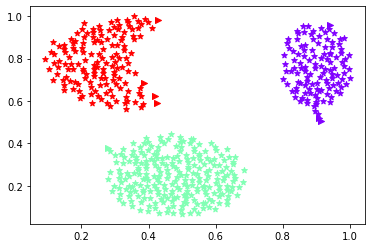

In [11]:
figure, axes = plt.subplots()
for value,color in zip(core_train.values(),colors):
    if value.size:
        x_core, y_core = np.hsplit(train_data_norm[value], 2)
        plt.scatter(x_core,y_core,marker='*',color=color)
for value,color in zip(border_train.values(),colors):
    if value.size:
        x_border, y_border = np.hsplit(train_data_norm[value], 2)
        plt.scatter(x_border,y_border,marker='>',color=color)
x_outlier, y_outlier = np.hsplit(train_data_norm[outlier_train], 2)
plt.scatter(x_outlier,y_outlier,marker='x',color=color)
draw_circle = []
j = 0
for i in range(x_outlier.shape[0]):
    draw_circle.append(plt.Circle((x_outlier[i,0], y_outlier[i,0]), radius, fill=False))
    axes.add_artist(draw_circle[j])
    j += 1
plt.show()

# Teste do modelo

In [12]:
test_result, test_outlier = dbscan_fit(test_data=test_data_norm, core_dict=core_train, radius_of_neighborhood=radius, train_data = train_data_norm)

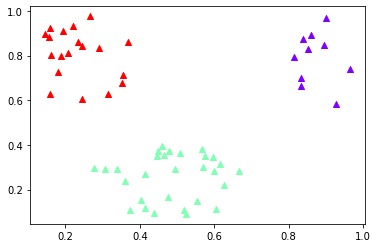

In [13]:
for value,color in zip(test_result.values(),colors):
    x_train, y_train = np.hsplit(test_data_norm[value], 2)
    plt.scatter(x_train,y_train,marker='^',color=color)
x_outlier_test, y_outlier_test = np.hsplit(test_data_norm[test_outlier], 2)
plt.scatter(x_outlier_test,y_outlier_test,marker='x',color='g')

# Junção do teste com o treino para plot e comparação:
* bolinhas são core points do treino
* estrelas são border points do treino
* Triangulos são os pontos pertencentes ao cluster de mesma cor
* se existir um X vermelho ou verde são pontos outliers do treino e do teste, respectivamente

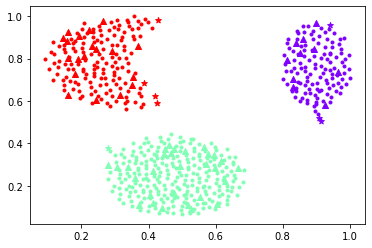

In [14]:
for value,color in zip(core_train.values(),colors):
    x_core, y_core = np.hsplit(train_data_norm[value], 2)
    plt.scatter(x_core,y_core,marker='.',color=color)
for value,color in zip(border_train.values(),colors):
    if value.size:
        x_border, y_border = np.hsplit(train_data_norm[value], 2)
        plt.scatter(x_border,y_border,marker='*',color=color)
for value,color in zip(test_result.values(),colors):
    x_test, y_test = np.hsplit(test_data_norm[value], 2)
    plt.scatter(x_test,y_test,marker='^',color=color)
x_outlier_train, y_outlier_train = np.hsplit(train_data_norm[outlier_train], 2)
x_outlier_test, y_outlier_test = np.hsplit(test_data_norm[test_outlier], 2)

plt.scatter(x_outlier_train,y_outlier_train,marker='x',color='r')
plt.scatter(x_outlier_test,y_outlier_test,marker='x',color='g')
plt.show()

## Até aqui a avaliação dos hiperparâmetros para o modelo foi feita no olhômetro, com testes e retreinos. Dessa forma, gostaríamos de avaliar automaticamente a qualidade dos modelos por métricas:

In [15]:
# fazer uma validação dos dados com métricas e gráficos? 
# Tentar fazer um elbow? 
# avaliar tudo isso?

# A partir daqui leitura e tratamento de um arquivo com um número maior de colunas

In [16]:
df_attribbutes = pd.read_csv('CC_GENERAL.csv', sep=',',header=0)

In [17]:
# Print dos dados para entender as colunas e seus dados
df_attribbutes

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,C19186,28.493517,1.000000,291.12,0.00,291.12,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,325.594462,48.886365,0.500000,6
8946,C19187,19.183215,1.000000,300.00,0.00,300.00,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,275.861322,NaN,0.000000,6
8947,C19188,23.398673,0.833333,144.40,0.00,144.40,0.000000,0.833333,0.000000,0.666667,0.000000,0,5,1000.0,81.270775,82.418369,0.250000,6
8948,C19189,13.457564,0.833333,0.00,0.00,0.00,36.558778,0.000000,0.000000,0.000000,0.166667,2,0,500.0,52.549959,55.755628,0.250000,6


In [18]:
# Limpeza de dado desnecessário
df_treated = df_attribbutes.drop(columns =['CUST_ID'])

In [19]:
# normalização dos dados
x = df_treated.values
min_max_scaler = preprocessing.MinMaxScaler()
df_scaled = min_max_scaler.fit_transform(x)

In [20]:
# divisão para dados de treinamento e dados de teste
np.random.shuffle(df_scaled)
train_index_norm = int(df_scaled.shape[0]*0.9)
train_data_norm,test_data_norm = np.vsplit(df_scaled,[train_index_norm])

## Treino do modelo para o dataset em questão

In [21]:
core_train_df, border_train_df, outlier_train_df, n_df = dbscan(data_in = train_data_norm, radius_of_neighborhood = radius, number_of_neighbors = nb_of_neighbors) 

In [22]:
# quantidade de clusters encontrados
n_df

37

In [23]:
# classificação dos clusters com seus pontos
core_train_df

{0: array([1348, 1706, 2159, 2222, 2816, 2903, 3254, 4042, 6209,  121,  922,
        6521,  719,  981, 1130, 1415, 2017, 2549, 2907, 3063, 4865, 4983,
        5184, 5762, 1924, 2342, 4095, 4112, 4651, 5688, 6243, 6679, 6771,
        4399,  409, 1232, 4437, 4476, 7228, 1935, 4035, 7207, 4088,  118,
         754, 1065, 2216, 2240, 2328, 3194, 3243, 4167, 4620, 5870, 6104,
        6320, 6831, 7303, 7670, 7942,  553,  560,  678,  867, 1665, 2049,
        2406, 2564, 3049, 3705, 3850, 4101, 4664, 6250, 1391, 2160, 3074,
        3381, 4896, 5482, 3056, 3678, 4425, 5745, 5766, 5903, 3716, 5493,
        2215, 7091,  223, 1135, 1404, 1745, 2096, 2818, 4023, 6807, 1667,
        5596,  487,  965, 1303, 3819, 6450, 7393, 5891, 3461, 7196, 6298,
         665, 1269, 1587, 2323, 2682, 3408, 3577, 4315, 6189, 2321, 3335,
        1405, 1781, 2035, 2257, 5445, 5657, 7094, 7403,  361,  643,  979,
        1016, 1031, 1085, 1246, 1252, 1310, 1815, 2219, 2228, 2394, 2753,
        2766, 3327, 3380, 3425, 356

In [24]:
# classificação dos clusters com seus pontos
border_train_df

{0: array([6725, 3914, 1078, 1663, 1660, 2813, 7052,  648, 5048, 6783, 4228,
        1138, 1795, 1464, 6535, 4454, 1009, 2176, 5394, 1602, 2719,  858,
        7102, 7621, 8019, 2073, 2595, 3934, 3547,  267, 6907, 7829, 5448,
        6544, 5053, 7890, 5513,  279, 1736, 7206, 5438,  372,  596, 1917,
        2192, 6174, 2493, 3630, 1291, 5064, 5773, 7664, 3683, 7759, 4715,
        4031, 1540, 4294, 3367, 7553, 4413, 7204, 6301, 2641, 3410, 1822,
        3712, 7577, 1093, 1541, 2708, 3663, 5694, 6534, 7876, 4569],
       dtype=int64),
 1: array([ 791, 2817, 6519, 2418, 7211, 7237, 4696, 8033, 2079, 1664, 3321,
        6040, 6455, 8054, 2747,  704, 3232, 3312, 1606, 1390, 6684, 7964,
        5771, 6357, 5946, 1044], dtype=int64),
 2: array([7442], dtype=int64),
 3: array([2080, 2492], dtype=int64),
 4: array([4003, 5247, 3798,  505, 2028, 4884,  876], dtype=int64),
 5: array([1787, 4152, 2638, 6364, 4387, 5901, 7771, 4375, 5786, 8034,  592,
        7076, 1834, 3088,  986, 1230, 2797, 3773, 

In [25]:
# Quantidade de outliers encontrados no treino
len(outlier_train_df)

6586

# Utilização de PCA para treinar o modelo!!!!

# TODO

In [26]:
#TO-DO
#PARTE DO PCA